In [ ]:
#https://www.joinquant.com/view/community/detail/08caab329d0b3cf48f88815a25e081f3

说  明：

1、选取了300ETF、50ETF、黄金ETF、商品ETF和纳指ETF作为研究对象；

2、对各ETF的日度-对数收益率进行了统计检验，均值、方差、偏度、峰度等指标进行了计算

3、通过蒙特卡罗生成了权重序列（w1,w2,w3,w4,w5）,然后计算组合的均值和方差

4、通过生成4万个权重序列，生成均值方差平面上的可行集

5、根据可行集生成了有效前沿

6、根据有效前沿，求出了方差最小的点、夏普最大的点

7、根据夏普最大的点对应的权重，生成一个投资组合

8、利用均值方差的方法生成的组合和按照等权组合进行对比


注：本文参照了陈小米。老师的文章

【组合管理】——投资组合理论（有效前沿）

https://www.joinquant.com/view/community/detail/4734d7772984cfca158cd2139ba55884?type=1

In [12]:
#导入个各种包
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
from datetime import *
import datetime
from matplotlib import rcParams
from functools import partial
import matplotlib as mpl
from functools import partial
# 设置默认绘图参数
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
mpl.rc('figure', figsize=(8,4), titlesize='xx-large', dpi=110)
mpl.rc('font', size=10)

### **1.选取几只ETF。**

大小盘：

159922.XSHE	500ETF	2013/3/15	etf

510050.XSHG	50ETF	2005/2/23	etf

商品：

159934.XSHE	黄金ETF	2013/12/16	etf

510170.XSHG	商品ETF	2011/1/25	etf

国外：

159941.XSHE	纳指ETF	2015/7/13	etf



In [13]:
etfs = ['159922.XSHE','510050.XSHG','159934.XSHE','510170.XSHG','159941.XSHE']
start_date = '2016-01-01'
end_date = '2023-07-09'

In [14]:
df = get_price(etfs, start_date=start_date, end_date=end_date, frequency='daily', 
               fields='close', skip_paused=False, fq='pre', count=None,  fill_paused=True)['close']
data= df.dropna()
data.head()

,159922.XSHE,510050.XSHG,159934.XSHE,510170.XSHG,159941.XSHE
2016-01-04,6.421,2.055,2.228,0.434,0.249
2016-01-05,6.354,2.062,2.265,0.441,0.244
2016-01-06,6.381,2.090,2.283,0.442,0.245
2016-01-07,6.165,1.963,2.317,0.411,0.242
2016-01-08,5.907,2.001,2.331,0.419,0.241


### **2.规范起点为100，画图展示**

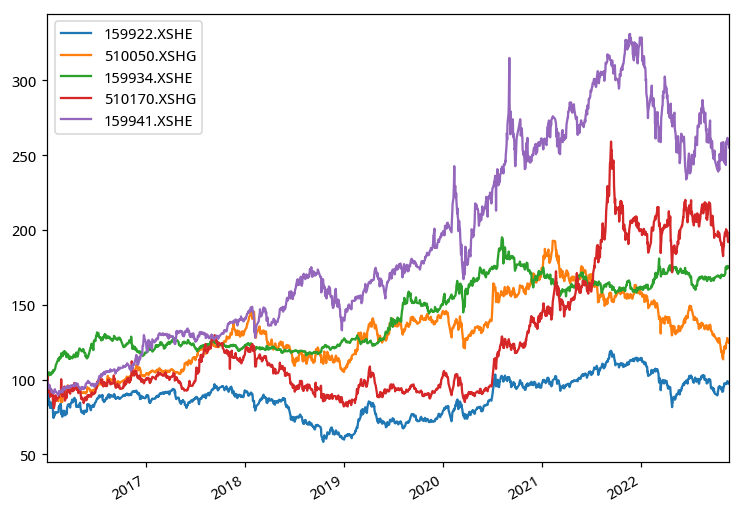

In [15]:
dataones = (data/data.ix[0]*100)
dataones.plot(figsize = (8,6))

### **3.计算收益率**

计算每天的对数收益率数据

In [16]:
log_returns = np.log(data/data.shift(1))
log_returns.head()

,159922.XSHE,510050.XSHG,159934.XSHE,510170.XSHG,159941.XSHE
2016-01-04,NaN,NaN,NaN,NaN,NaN
2016-01-05,-0.010489,0.003401,0.016470,0.016000,-0.020285
2016-01-06,0.004240,0.013488,0.007916,0.002265,0.004090
2016-01-07,-0.034437,-0.062690,0.014783,-0.072717,-0.012320
2016-01-08,-0.042750,0.019173,0.006024,0.019278,-0.004141


### **4.输出每只ETF收益率的统计数据**

In [17]:
#定义print_statistics函数，为了更加易于理解的方式
#输出给定(历史或者模拟)数据集均值、偏斜度或者峰度等统计数字
def print_statistics(array):
    sta = scs.describe(array)
    print '%14s %15s' %('statistic','value')
    print 30*'-'
    print '%14s %15d' %('size', sta[0])
    print '%14s %15.5f' %('min', sta[1][0])
    print '%14s %15.5f' %('max', sta[1][1])
    print '%14s %15.5f' %('mean', sta[2])
    print '%14s %15.5f' %('std', np.sqrt(sta[3]))
    print '%14s %15.5f' %('skew', sta[4])
    print '%14s %15.5f' %('kurtosis', sta[5])

for st in etfs:
    print '\nResults for stock %s' %st
    print 30*'-'
    log_data = np.array(log_returns[st].dropna())
    print_statistics(log_data)


Results for stock 159922.XSHE
------------------------------
     statistic           value
------------------------------
          size            1674
           min        -0.09854
           max         0.05383
          mean        -0.00002
           std         0.01367
          skew        -0.91483
      kurtosis         5.12923

Results for stock 510050.XSHG
------------------------------
     statistic           value
------------------------------
          size            1674
           min        -0.07741
           max         0.08497
          mean         0.00013
           std         0.01236
          skew        -0.16957
      kurtosis         4.75254

Results for stock 159934.XSHE
------------------------------
     statistic           value
------------------------------
          size            1674
           min        -0.06342
           max         0.05408
          mean         0.00033
           std         0.00822
          skew        -0.18745
      ku

### **5.进行正态性检验**

In [18]:
def normality_test(array):
    '''
    对给定的数据集进行正态性检验
    组合了3中统计学测试
    偏度测试（Skewtest）——足够接近0
    峰度测试（Kurtosistest)——足够接近0
    正态性测试
    '''
    print 'Skew of data set %15.3f' % scs.skew(array)
    print 'Skew test p-value %14.3f' % scs.skewtest(array)[1]
    print 'Kurt of data set %15.3f' % scs.kurtosis(array)
    print 'Kurt test p-value %14.3f' % scs.kurtosistest(array)[1]
    print 'Norm test p-value %14.3f' % scs.normaltest(array)[1]

for st in etfs:
    print '\nResults for st %s' %st
    print 32*'-'
    log_data = np.array(log_returns[st].dropna())
    normality_test(log_data)


Results for st 159922.XSHE
--------------------------------
Skew of data set          -0.915
Skew test p-value          0.000
Kurt of data set           5.129
Kurt test p-value          0.000
Norm test p-value          0.000

Results for st 510050.XSHG
--------------------------------
Skew of data set          -0.170
Skew test p-value          0.005
Kurt of data set           4.753
Kurt test p-value          0.000
Norm test p-value          0.000

Results for st 159934.XSHE
--------------------------------
Skew of data set          -0.187
Skew test p-value          0.002
Kurt of data set           6.392
Kurt test p-value          0.000
Norm test p-value          0.000

Results for st 510170.XSHG
--------------------------------
Skew of data set          -0.297
Skew test p-value          0.000
Kurt of data set           3.729
Kurt test p-value          0.000
Norm test p-value          0.000

Results for st 159941.XSHE
--------------------------------
Skew of data set          -0.472
Sk

## PART TWO：均值-方差投资组合理论

该理论基于用均值和方差来表述组合的优劣的前提。将选取几只股票，用蒙特卡洛模拟初步探究组合的有效前沿。

通过最大Sharpe和最小方差两种优化来找到最优的资产组合配置权重参数。

最后，刻画出可能的分布，两种最优以及组合的有效前沿。



### **1.计算不同证券的均值、协方差**

每年252个交易日，用每日收益得到年化收益。

计算投资资产的协方差是构建资产组合过程的核心部分。运用pandas内置方法生产协方差矩阵。

In [19]:
returns = np.log(data / data.shift(1))
returns.mean()*252

159922.XSHE   -0.004087
510050.XSHG    0.033665
159934.XSHE    0.084011
510170.XSHG    0.098149
159941.XSHE    0.140929
dtype: float64

In [20]:
#协方差
returns.cov()*252

,159922.XSHE,510050.XSHG,159934.XSHE,510170.XSHG,159941.XSHE
159922.XSHE,0.047075,0.027660,-0.000873,0.032988,0.016844
510050.XSHG,0.027660,0.038482,-0.000819,0.022187,0.016728
159934.XSHE,-0.000873,-0.000819,0.017011,0.004584,-0.001750
510170.XSHG,0.032988,0.022187,0.004584,0.079324,0.014028
159941.XSHE,0.016844,0.016728,-0.001750,0.014028,0.055732


In [21]:
#相关性
returns.corr()

,159922.XSHE,510050.XSHG,159934.XSHE,510170.XSHG,159941.XSHE
159922.XSHE,1.000000,0.649878,-0.030852,0.539836,0.328848
510050.XSHG,0.649878,1.000000,-0.032003,0.401571,0.361217
159934.XSHE,-0.030852,-0.032003,1.000000,0.124790,-0.056849
510170.XSHG,0.539836,0.401571,0.124790,1.000000,0.210974
159941.XSHE,0.328848,0.361217,-0.056849,0.210974,1.000000


### **2.给不同资产随机分配初始权重**

由于A股不允许建立空头头寸，所有的权重系数均在0-1之间

In [22]:
noa = len(returns.mean()*252)
#生成noa个【0-1】之间的随机数
weights = np.random.random(noa)
weights /= np.sum(weights)
weights


array([0.545818453014, 0.0654161039773, 0.129651978354, 0.0874162585662,
       0.171697206088])

### **3.计算预期组合年化收益、组合方差和组合标准差**
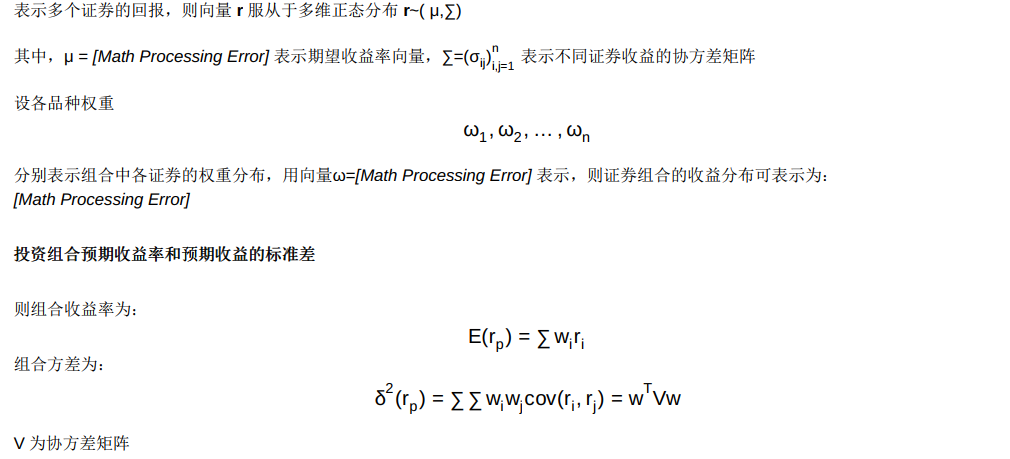

In [23]:
#投资组合的均值
np.sum(returns.mean()*weights)*252

0.043640397074313886

In [24]:
#投资组合的方差  1*5-5*5-5*1
np.dot(weights.T, np.dot(returns.cov()*252,weights))

0.025943454549824604

In [25]:
#投资组合的标准差
np.sqrt(np.dot(weights.T, np.dot(returns.cov()* 252,weights)))

0.16106971953109189

### **4.用蒙特卡洛模拟产生大量随机组合**

生成可行集合

通过蒙特卡洛模拟，产生大量随机的权重向量，并记录随机组合的预期收益和方差。

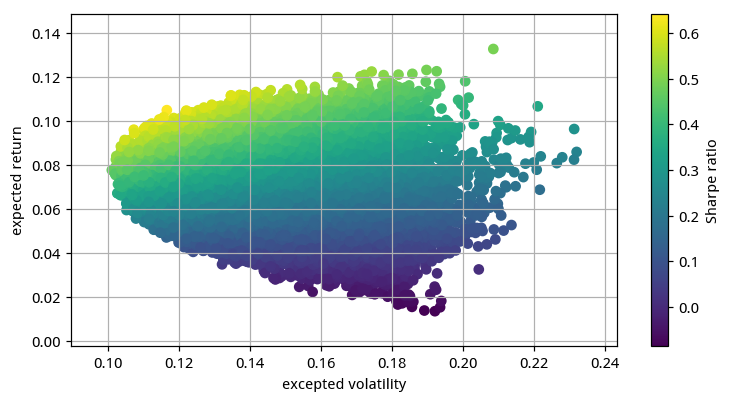

In [26]:
port_returns = []
port_variance = []
#生成4万组权重随机变量，并归一化处理
for p in range(40000):
    weights = np.random.random(noa)
    weights /=np.sum(weights)
    port_returns.append(np.sum(returns.mean()*252*weights))
    port_variance.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights))))

port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

#无风险利率设定为3%,画出可行集
risk_free = 0.03
plt.figure(figsize = (8,4))
plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker = 'o')
plt.grid(True)
plt.xlabel('excepted volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

### **5.投资组合优化1——sharpe最大**

定义【statistics】函数输入配置权重，返回组合收益、方差和夏普比

然后通过最优化函数求解，夏普最大点

In [27]:
def statistics(weights):
    weights = np.array(weights)
    port_returns = np.sum(returns.mean()*weights)*252
    port_variance = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252,weights)))
    return np.array([port_returns, port_variance, port_returns/port_variance])


In [28]:
#最优化投资组合的推导是一个约束最优化问题
import scipy.optimize as sco

#最小化夏普指数的负值，求最小相当于求最大夏普
def min_sharpe(weights):
    return -statistics(weights)[2]

In [29]:
min_sharpe(weights)

-0.5313895628565507

In [30]:
#约束是所有参数(权重)的总和为1。这可以用minimize函数的约定表达如下
cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})

#我们还将参数值(权重)限制在0和1之间。这些值以多个元组组成的一个元组形式提供给最小化函数
bnds = tuple((0,1) for x in range(noa))

#优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
opts = sco.minimize(min_sharpe, noa*[1./noa,], method = 'SLSQP', bounds = bnds, constraints = cons)
opts

  status: 0
 success: True
    njev: 5
    nfev: 37
     fun: -0.9140744542423348
       x: array([1.57892904525e-17, 7.50275153513e-17, 0.623821824225,
       0.0604380615346, 0.31574011424])
 message: 'Optimization terminated successfully.'
     jac: array([0.525055773556, 0.142157785594, -0.000275559723377,
       0.000195883214474, 0.000506944954395, 0.0])
     nit: 5

得到的最优组合**权重向量**为：

In [31]:
opts['x'].round(3)

array([0.0, 0.0, 0.624, 0.06, 0.316])

sharpe最大的组合3个**统计数据**分别为：

In [32]:
#预期收益率、预期波动率、最优夏普指数
statistics(opts['x']).round(3)

array([0.103, 0.113, 0.914])

### **5.投资组合优化2——方差最小**

接下来，我们通过方差最小来选出最优投资组合。

In [33]:
#但是我们定义一个函数对 方差进行最小化
def min_variance(weights):
    return statistics(weights)[1]

optv = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
optv

  status: 0
 success: True
    njev: 9
    nfev: 63
     fun: 0.10095080823985132
       x: array([0.0884429599914, 0.159129498418, 0.625174507408, 1.19262238973e-18,
       0.127253034183])
 message: 'Optimization terminated successfully.'
     jac: array([0.10066859331, 0.100909010507, 0.101085465401, 0.109944762662,
       0.100537681021, 0.0])
     nit: 9

方差最小的最优组合**权重向量**及**组合的统计数据**分别为：

In [34]:
optv['x'].round(3)

array([0.088, 0.159, 0.625, 0.0, 0.127])

In [35]:
#得到的预期收益率、波动率和夏普指数
statistics(optv['x']).round(3)

array([0.075, 0.101, 0.747])

### **6.组合的有效前沿**

有效前沿有既定的目标收益率下方差最小的投资组合构成。

在最优化时采用两个约束，1.给定目标收益率，2.投资组合权重和为1。

In [39]:
def min_variance(weights):
    return statistics(weights)[1]

#在不同目标收益率水平（target_returns）循环时，最小化的一个约束条件会变化。
target_returns = np.linspace(0.0,0.13,100)
target_variance = []
#返还最小方差
for tar in target_returns:
    cons = ({'type':'eq','fun':lambda x:statistics(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
    target_variance.append(res['fun'])

target_variance = np.array(target_variance)

In [38]:
#选取最小方差值为起点构建有效前沿
ind=np.argmin(target_variance)
e_std = target_variance[ind:]
e_returns=target_returns[ind:]

下面是最优化结果的展示。

**叉号**：构成的曲线是有效前沿（目标收益率下最优的投资组合）

**红星**：sharpe最大的投资组合

**黄星**：方差最小的投资组合

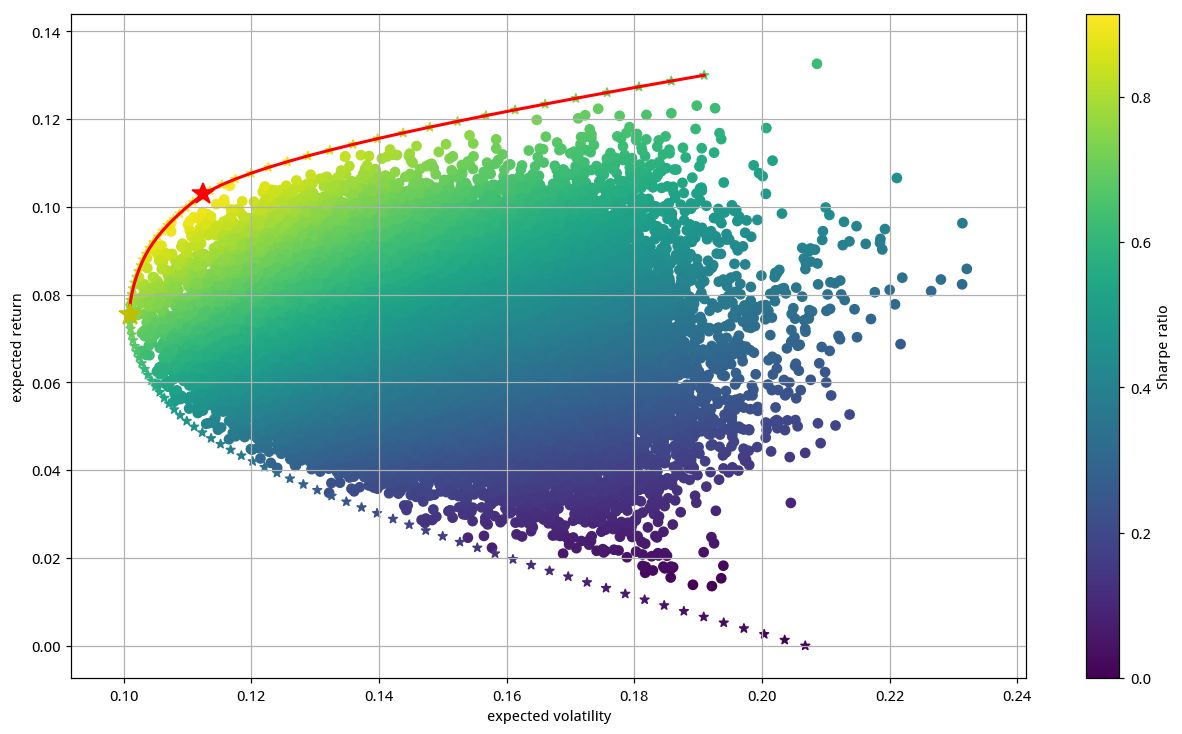

In [40]:
plt.figure(figsize = (14,8))
#圆圈：蒙特卡洛随机产生的组合分布
plt.scatter(port_variance, port_returns, c = port_returns/port_variance,marker = 'o')
#叉号：有效前沿
plt.scatter(target_variance,target_returns, c = target_returns/target_variance, marker = '*')
#有效前沿
plt.plot(e_std,e_returns, linewidth=2,color='red')
#红星：标记最高sharpe组合
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize = 15.0)
#黄星：标记最小方差组合
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize = 15.0)


plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

In [41]:
#最大夏普点的权重，由于计算误差因素，求和不完全等于1，在归一化一下
masharpwei = opts['x']/(opts['x'].sum())

In [42]:
#在原来数据中添加均值方差模型构建的组合和等权配置的组合
dataones['var-mean'] = (dataones.iloc[:,0:5]*masharpwei).sum(axis=1)
dataones['mean'] = (dataones.iloc[:,0:5]).mean(axis=1)

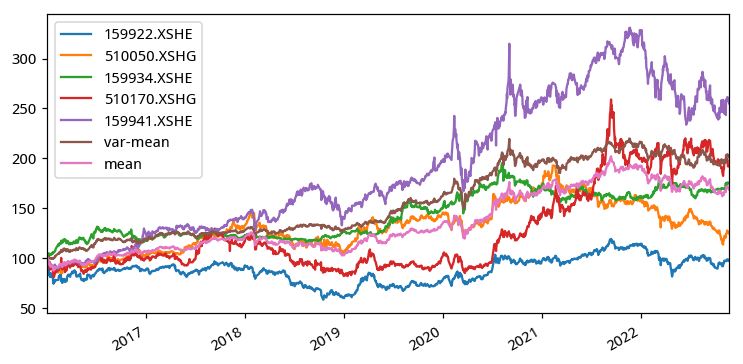

In [43]:
dataones.plot()

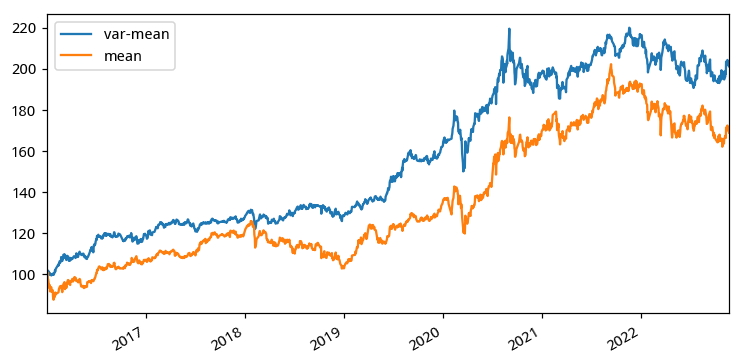

In [45]:
#对比两个组合表现
dataones[['var-mean','mean']].plot()